In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# 1. Muat data dari folder dataset
# Tentukan path ke folder dataset Anda
dataset_path = '/content/drive/MyDrive/dataset'

# Tentukan parameter untuk memuat data
image_size = (224, 224)
batch_size = 32

# Muat data pelatihan dan validasi secara otomatis
# Validation_split akan membagi dataset menjadi set pelatihan dan validasi
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Dapatkan nama-nama kelas dari dataset
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Nama-nama kelas yang terdeteksi: {class_names}")
print(f"Jumlah data pelatihan: {len(train_ds) * batch_size}")
print(f"Jumlah data validasi: {len(val_ds) * batch_size}")

# Normalisasi data
# Karena kita menggunakan ResNet, kita perlu menormalisasi data sesuai dengan persyaratan model
normalization_layer = tf.keras.applications.resnet50.preprocess_input
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Konfigurasi untuk kinerja yang lebih baik
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 500 files belonging to 10 classes.
Using 400 files for training.
Found 500 files belonging to 10 classes.
Using 100 files for validation.
Nama-nama kelas yang terdeteksi: ['Rusip', 'belacan', 'bong li piang', 'kretek', 'lakso', 'lempah kuning', 'martabak bangka', 'mie koba', 'otak-otak', 'sambelingkung']
Jumlah data pelatihan: 416
Jumlah data validasi: 128


In [14]:
# --- 2. Bangun Model dengan Transfer Learning ---
# Muat model ResNet50 yang sudah terlatih sebelumnya (pre-trained)
# Termasuk lapisan atas (top layers) kita atur ke False karena kita akan menggantinya
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Bekukan lapisan-lapisan dasar agar tidak dilatih ulang
for layer in base_model.layers:
    layer.trainable = False

# Bangun model baru di atas model dasar
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


# --- 3. Latih Model ---
# Kompilasi model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Mulai pelatihan
epochs = 10
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]  # Sertakan callback di sini
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1950 - loss: 2.5060
Epoch 1: val_accuracy improved from -inf to 0.73000, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.2078 - loss: 2.4613 - val_accuracy: 0.7300 - val_loss: 0.8405
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9004 - loss: 0.5265
Epoch 2: val_accuracy improved from 0.73000 to 0.93000, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.9016 - loss: 0.5185 - val_accuracy: 0.9300 - val_loss: 0.2795
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9723 - loss: 0.1674
Epoch 3: val_accuracy improved from 0.93000 to 0.95000, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.9725 - loss: 0.1657 - val_accuracy: 0.9500 - val_loss: 0.2039
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9930 - loss: 0.0857
Epoch 4: val_accuracy improved from 0.95000 to 0.96000, s


--- Grafik Performa Model ---


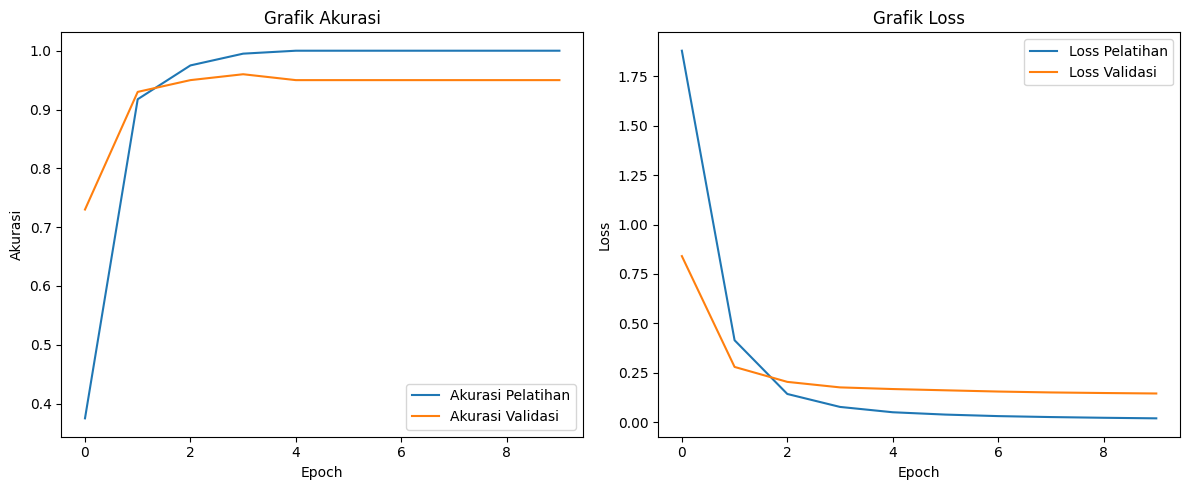


--- Confusion Matrix ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step


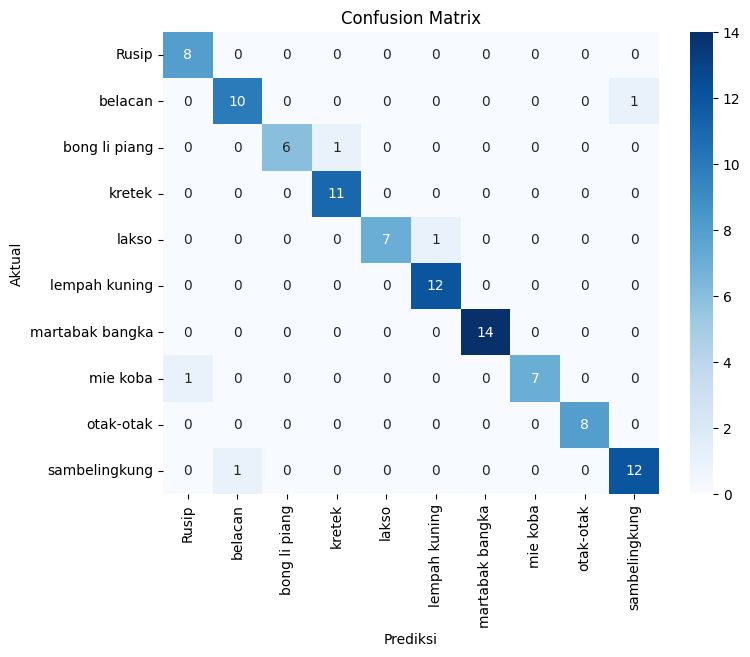

In [16]:
# --- 4. Evaluasi dan Visualisasi ---
print("\n--- Grafik Performa Model ---")
# Plot grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Buat Confusion Matrix
print("\n--- Confusion Matrix ---")
# Kumpulkan semua label dan prediksi dari set validasi
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Buat dan plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()